In [3]:
import pandas as pd
import numpy as np
import re
import os
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Construct matrices for HC and SZ groups

In [25]:
def load_significant_lipid_names(csv_path):
    """Loads lipid names from a CSV file into a set for quick lookup."""
    lipid_names_df = pd.read_csv(csv_path)
    return set(lipid_names_df['Significant Lipids'])

def calc_and_save_correlation_matrices(group_data, group_name, significant_lipids):
    output_dir = f'./NEW_lipids_{group_name}'
    os.makedirs(output_dir, exist_ok=True)

    # Filter lipid columns based on the significant lipids list
    lipid_columns = [col for col in group_data.columns if col in significant_lipids]

    for lipid_col in lipid_columns:
        # For each significant lipid, pivot the data to have donors as rows and regions as columns
        pivot_table = group_data.pivot_table(index='Donor', columns='Region', values=lipid_col, aggfunc=np.mean)

        # Calculate the correlation matrix across regions for this lipid
        correlation_matrix = pivot_table.corr()
        correlation_matrix.reset_index(inplace=True)
        
        # Save the correlation matrix to CSV without the index
        safe_lipid_col_name = re.sub(r'[^\w\s]', '_', lipid_col)  # Replace non-alphanumeric characters with underscore
        file_name = f"{output_dir}/{group_name}_{safe_lipid_col_name}_correlation_matrix.csv"
        correlation_matrix.to_csv(file_name, index=False)

# Load significant lipids from CSV
csv_path = 'dots_Names_of_significant_lipids.csv'  # Adjust this path
significant_lipids = load_significant_lipid_names(csv_path)

# Assume 'data' is your DataFrame
# Extract donor groups from the 'Donor' column
donor_groups = data['Donor'].str.extract(r'(HC|SZ|MDD)')[0].dropna().unique()

for group in donor_groups:
    if isinstance(group, str):
        # Filter data for each donor group
        group_data = data[data['Donor'].str.contains(group, na=False)]
        calc_and_save_correlation_matrices(group_data, group, significant_lipids)
    else:
        print(f"Skipped group {group} due to non-string value.")

# 2. Calculate matrices of differences HC-SZ for lipids

In [26]:
# Define directories
sz_matrices_dir = './NEW_lipids_SZ'
hc_matrices_dir = './NEW_lipids_HC'
difference_matrices_dir = './NEW_HC_SZ_lipids_difference_matrices'
os.makedirs(difference_matrices_dir, exist_ok=True)

# Get the list of matrix files for SZ and HC
sz_files = os.listdir(sz_matrices_dir)
hc_files = os.listdir(hc_matrices_dir)

# Loop through SZ files to find matching HC files
for sz_file in sz_files:
    sz_lipid_name = sz_file.replace('SZ_', '').replace('_correlation_matrix.csv', '')
    hc_file = next((hc for hc in hc_files if sz_lipid_name in hc), None)
    
    if hc_file:
        # Load the SZ and HC matrices
        sz_matrix = pd.read_csv(os.path.join(sz_matrices_dir, sz_file), index_col=0)
        hc_matrix = pd.read_csv(os.path.join(hc_matrices_dir, hc_file), index_col=0)
        
        # Ensure the matrices have the same size and labels
        if sz_matrix.shape == hc_matrix.shape and np.all(sz_matrix.index == hc_matrix.index):
            # Calculate the difference matrix
            difference_matrix = hc_matrix - sz_matrix
            
            # Save the difference matrix
            diff_file_name = f'DIFF_{sz_lipid_name}_correlation_matrix.csv'
            difference_matrix.to_csv(os.path.join(difference_matrices_dir, diff_file_name))
        else:
            print(f"Matrix size or labels mismatch for lipid: {sz_lipid_name}")
    else:
        print(f"No matching HC file for SZ file: {sz_file}")

print("Difference matrices have been saved.")

Difference matrices have been saved.


# Visualization of first 25 matrices HC-SZ

In [3]:
# difference_matrices_dir = './NEW_HC_SZ_lipids_difference_matrices'

# # Get all the difference matrix file names in the directory
# difference_files = os.listdir(difference_matrices_dir)
# difference_files.sort()  # Sort the list to get a consistent order

# # Take only the first 25 files for plotting
# first_twenty_five_files = difference_files[:25]
# fig, axes = plt.subplots(5, 5, figsize=(20, 20))
# axes = axes.flatten()

# # Loop over the first 25 files and plot each matrix
# for i, file in enumerate(first_twenty_five_files):
#     matrix_path = os.path.join(difference_matrices_dir, file)
#     difference_matrix = pd.read_csv(matrix_path, index_col=0)

#     # Plot the matrix
#     ax = axes[i]
#     cax = ax.matshow(difference_matrix, cmap='viridis', aspect='auto')
#     fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)
#     ax.set_title(file.replace('_correlation_matrix.csv', ''), pad=20, fontsize=8)

#     # Remove ticks
#     ax.set_xticks([])
#     ax.set_yticks([])

# # # Adjust layout to prevent overlap
# # plt.tight_layout()
# # plt.show()

# Print shape for DIFF matrices 

In [36]:
directory_path = './NEW_HC_SZ_lipids_difference_matrices'
file_shapes = []

# Loop through each file in the directory
for filename in os.listdir(directory_path):
    file_path = os.path.join(directory_path, filename)
    
    # Check if the file is a CSV before reading
    if file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
        file_shapes.append((filename, df.shape))

# for filename, shape in file_shapes:
#     print(f"File: {filename}, Shape: {shape}")

# 3. Load HC-SZ for fMRI COBRE

In [56]:
difference_matrix_HC_SZ_COBRE = pd.read_csv("SZHCresults_COBRE.csv", index_col=0)
difference_matrix_HC_SZ_COBRE

,AnG,BLA,Ca,CBL,CgGc,CgGr,swm_Cun,IFGa,MTG,ITGp,SPL,swm_MFG,PoCG,PrCG,PrCun,Pu,SFGp,STGp,swm_AnG,TTG
AnG,0.000000,0.043142,0.078973,0.072488,0.012734,0.083261,0.071806,0.058825,0.079154,0.071238,0.056602,0.062065,0.092160,0.088817,0.082684,0.079205,0.088390,0.149771,0.080701,0.082284
BLA,0.043142,0.000000,0.020310,0.012168,0.040508,0.035884,0.102404,0.008586,0.039493,0.002600,0.073376,0.089745,0.082218,0.102182,0.086289,0.025056,0.052939,0.092223,0.048076,0.078632
Ca,0.078973,0.020310,0.000000,-0.001724,0.098267,0.079105,0.102782,0.037008,0.031451,0.027351,0.123171,0.093477,0.089442,0.076464,0.149289,0.019667,0.047999,0.050416,0.036888,0.020518
CBL,0.072488,0.012168,-0.001724,0.000000,0.050249,0.018153,0.093917,0.023377,0.014774,0.046031,0.053158,0.073883,0.038799,0.056548,0.055211,0.018401,0.054743,0.003779,0.012554,-0.048777
CgGc,0.012734,0.040508,0.098267,0.050249,0.000000,0.076414,0.108933,0.083272,0.086771,0.081975,0.097681,0.076775,0.112511,0.106936,0.042047,0.075712,0.090142,0.130843,0.054616,0.065418
CgGr,0.083261,0.035884,0.079105,0.018153,0.076414,0.000000,0.104069,0.084624,0.087939,0.081380,0.106499,0.094338,0.072318,0.083113,0.025656,0.074064,0.111748,0.118997,0.044627,0.093752
swm_Cun,0.071806,0.102404,0.102782,0.093917,0.108933,0.104069,0.000000,0.127627,0.158545,0.102499,0.058003,0.116837,0.081296,0.085682,0.032194,0.101205,0.107678,0.164673,0.090696,0.107916
IFGa,0.058825,0.008586,0.037008,0.023377,0.083272,0.084624,0.127627,0.000000,0.014103,0.035499,0.074182,0.081130,0.098829,0.068636,0.112878,0.055604,0.081257,0.094998,0.095427,0.102177
MTG,0.079154,0.039493,0.031451,0.014774,0.086771,0.087939,0.158545,0.014103,0.000000,0.021328,0.136501,0.084753,0.161875,0.114366,0.161463,0.055238,0.089008,0.132217,0.099315,0.100058
ITGp,0.071238,0.002600,0.027351,0.046031,0.081975,0.081380,0.102499,0.035499,0.021328,0.000000,0.127461,0.099523,0.087977,0.079768,0.145412,0.020940,0.089126,0.083073,0.085048,0.073850


Text(0.5, 1.0, 'Correlation Matrix HC-SZ fMRI')

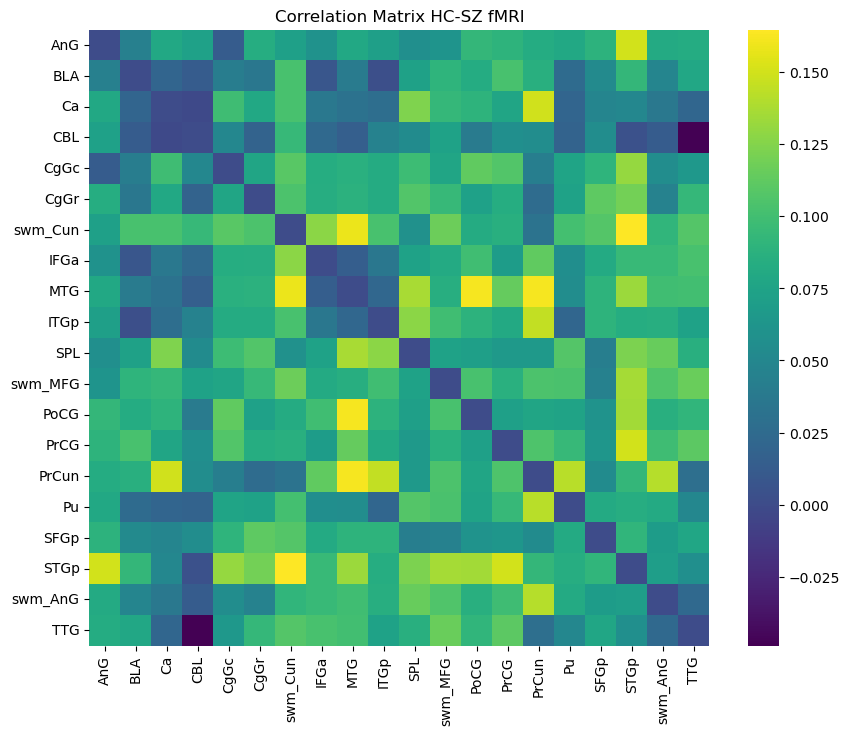

In [58]:
plt.figure(figsize=(10, 8))
sns.heatmap(difference_matrix_HC_SZ_COBRE, cmap='viridis', annot=False, fmt=".2f")
plt.title('Correlation Matrix HC-SZ fMRI')

# 4. Estimate corr b/w fMRI and lipids

In [39]:
directory_path = './NEW_HC_SZ_lipids_difference_matrices'
specific_matrix_path = 'SZHCresults_COBRE.csv'

# Load the specific matrix with row and column names
specific_matrix_df = pd.read_csv(specific_matrix_path, index_col=0)
specific_row_names = specific_matrix_df.index
specific_col_names = specific_matrix_df.columns

In [35]:
correlation_coefficients = []

# Iterate over each matrix file in the directory
for filename in os.listdir(directory_path):
    file_path = os.path.join(directory_path, filename)
    
    # Load each matrix with row and column names
    dir_matrix_df = pd.read_csv(file_path, index_col=0)
    dir_row_names = dir_matrix_df.index
    dir_col_names = dir_matrix_df.columns
    
    # Identify common rows and columns by names
    common_rows = specific_row_names.intersection(dir_row_names)
    common_cols = specific_col_names.intersection(dir_col_names)
    
    # Align the matrices based on common row and column names
    aligned_specific_matrix = specific_matrix_df.loc[common_rows, common_cols].values
    aligned_dir_matrix = dir_matrix_df.loc[common_rows, common_cols].values
    
    # Flatten the aligned sections
    flat_specific_matrix = aligned_specific_matrix.flatten()
    flat_dir_matrix = aligned_dir_matrix.flatten()
    
    # Calculate and store the Pearson correlation coefficient
    correlation_coefficient = np.corrcoef(flat_specific_matrix, flat_dir_matrix)[0, 1]
    correlation_coefficients.append((filename, correlation_coefficient))

    

# for filename, coefficient in correlation_coefficients:
#     print(f"File: {filename}, Correlation Coefficient: {coefficient}")

# 5. Permutation test

In [59]:
n_permutations = 10000

# Directory for saving permutation matrices
permutation_matrices_dir = './NEW_permutation_matrices'
specific_matrix_path = 'SZHCresults_COBRE.csv'
directory_path = './NEW_HC_SZ_lipids_difference_matrices'

if not os.path.exists(permutation_matrices_dir):
    os.makedirs(permutation_matrices_dir)
    
def shuffle_columns(df):
    return df.apply(np.random.permutation, axis=0)

specific_matrix_df = pd.read_csv(specific_matrix_path, index_col=0)
significant_results = []
original_corrs = []
all_perm_corrs = []

In [60]:
for filename in os.listdir(directory_path):
    file_path = os.path.join(directory_path, filename)
    dir_matrix_df = pd.read_csv(file_path, index_col=0)
    
    common_rows = specific_matrix_df.index.intersection(dir_matrix_df.index)
    common_cols = specific_matrix_df.columns.intersection(dir_matrix_df.columns)
    aligned_specific_matrix = specific_matrix_df.loc[common_rows, common_cols]
    aligned_dir_matrix = dir_matrix_df.loc[common_rows, common_cols]
    
    original_corr = np.corrcoef(aligned_specific_matrix.values.flatten(), aligned_dir_matrix.values.flatten())[0, 1]
    original_corrs.append(original_corr)
    
    perm_corrs = []
    for i in range(n_permutations):
        permuted = shuffle_columns(aligned_dir_matrix)
        perm_corr = np.corrcoef(aligned_specific_matrix.values.flatten(), permuted.values.flatten())[0, 1]
        perm_corrs.append(perm_corr)
        permuted.to_csv(os.path.join(permutation_matrices_dir, f'perm_matrix_{i}_{filename}'))

    all_perm_corrs.extend(perm_corrs)
    
    mean_perm_corr = np.mean(perm_corrs)  # Summary statistic
    significant_results.append((filename, original_corr, mean_perm_corr))
    print(f"File: {filename}, Original Correlation: {original_corr:.4f}, Permutation Correlation: {mean_perm_corr:.4f}")

File: DIFF_PC_40_5_PC_18_1_22_4_correlation_matrix.csv, Original Correlation: -0.0244, Permutation Correlation: -0.0078
File: DIFF_PE_40_4_PE_18_0_22_4_correlation_matrix.csv, Original Correlation: 0.0597, Permutation Correlation: 0.0221
File: DIFF_PC_42_3_PC_18_1_24_2_correlation_matrix.csv, Original Correlation: 0.0148, Permutation Correlation: -0.0227
File: DIFF_PC_42_5_PC_20_1_22_4_1_correlation_matrix.csv, Original Correlation: -0.0346, Permutation Correlation: 0.0108
File: DIFF_SM_35_2_2O_SM_18_1_O2_17_1_correlation_matrix.csv, Original Correlation: -0.2772, Permutation Correlation: -0.0692
File: DIFF_PC_38_7_PC_16_1_22_6_correlation_matrix.csv, Original Correlation: 0.0604, Permutation Correlation: 0.0313
File: DIFF_BMP_44_11_BMP_22_5_22_6_correlation_matrix.csv, Original Correlation: -0.1683, Permutation Correlation: -0.0396
File: DIFF_FA_20_2_correlation_matrix.csv, Original Correlation: 0.1531, Permutation Correlation: 0.0479
File: DIFF_PE_34_2_PE_16_0_18_2_correlation_matrix

# 6. Coefficient distribution plots

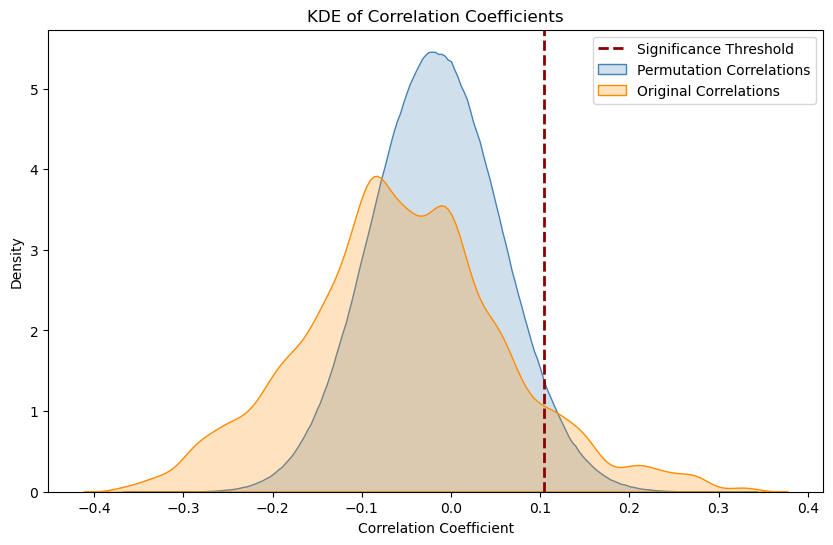

In [16]:
plt.figure(figsize=(10, 6))
# KDE plot for permuted correlation coefficients
sns.kdeplot(all_perm_corrs, bw_adjust=0.5, fill=True, color='steelblue', label='Permutation Correlations')
# KDE plot for original correlation coefficients
sns.kdeplot(original_corrs, bw_adjust=0.5, fill=True, color='darkorange', label='Original Correlations')

# Mark the significance level on the plot
# The critical value is the value below which a certain percentage of data falls
# Let's say we're using a 95% confidence, which is typical
significance_level = 0.05
critical_value = np.percentile(all_perm_corrs, (1 - significance_level) * 100)

# Add a vertical line for the significance threshold
plt.axvline(x=critical_value, color='darkred', linestyle='--', linewidth=2, label='Significance Threshold')

plt.title('KDE of Correlation Coefficients')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Density')
plt.legend()
plt.show()

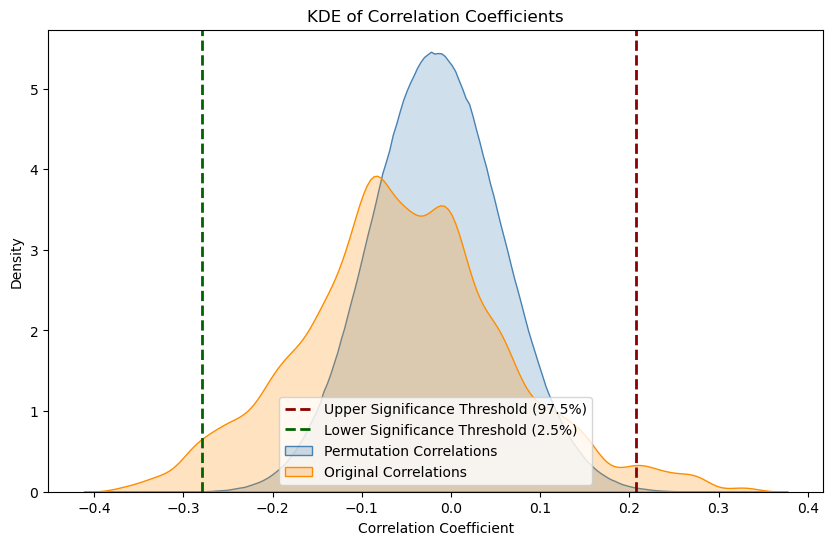

In [64]:
plt.figure(figsize=(10, 6))
# KDE plot for permuted correlation coefficients
sns.kdeplot(all_perm_corrs, bw_adjust=0.5, fill=True, color='steelblue', label='Permutation Correlations')
# KDE plot for original correlation coefficients
sns.kdeplot(original_corrs, bw_adjust=0.5, fill=True, color='darkorange', label='Original Correlations')

# Mark the significance level on the plot
# The critical value is the value below which a certain percentage of data falls
# Let's say we're using a 95% confidence, which is typical
# Set significance levels for both positive and negative critical values
upper_significance_level = 0.975
lower_significance_level = 0.025

# Calculate critical values
upper_critical_value = np.percentile(original_corrs, upper_significance_level * 100)
lower_critical_value = np.percentile(original_corrs, lower_significance_level * 100)

# Add vertical lines for the significance thresholds
plt.axvline(x=upper_critical_value, color='darkred', linestyle='--', linewidth=2, label='Upper Threshold (97.5%)')
plt.axvline(x=lower_critical_value, color='darkgreen', linestyle='--', linewidth=2, label='Lower Threshold (2.5%)')

plt.title('KDE of Correlation Coefficients')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Density')
plt.legend()
plt.show()

# 6.1 Define statistically significant lipids

In [17]:
# Create a dictionary to map filenames to original correlations
file_correlation_dict = {filename: original_corr for filename, original_corr, _ in significant_results}

# Determine the critical value for the permuted correlations
critical_value = np.percentile(all_perm_corrs, 95)

# Identify which files have significant correlations
significant_files = {file: corr for file, corr in file_correlation_dict.items() if corr > critical_value}

print("Files with significant correlations:")
for file, corr in significant_files.items():
    print(f"{file}: {corr}")

Files with significant correlations:
DIFF_FA_20_2_correlation_matrix.csv: 0.15313555222796882
DIFF_PC_38_4_PC_18_1_20_3_1_correlation_matrix.csv: 0.21870153504980847
DIFF_PE_O_39_7_PE_O_17_1_22_6_correlation_matrix.csv: 0.2391134720525661
DIFF_PC_O_36_5_correlation_matrix.csv: 0.1070580001188419
DIFF_PC_31_0_PC_15_0_16_0_correlation_matrix.csv: 0.10386828224062736
DIFF_PC_38_6_PC_16_0_22_6_1_correlation_matrix.csv: 0.1562345350882706
DIFF_PC_58_10_PC_36_4_22_6_correlation_matrix.csv: 0.1318195523926953
DIFF_MGDG_42_1_MGDG_16_0_26_1_correlation_matrix.csv: 0.15660525268087555
DIFF_LPE_22_4_correlation_matrix.csv: 0.12187071856071133
DIFF_PC_O_49_4_PC_O_28_2_21_2_correlation_matrix.csv: 0.13903351711407075
DIFF_PC_41_11_PC_19_5_22_6_correlation_matrix.csv: 0.2697637158355166
DIFF_PC_39_6_PC_17_0_22_6_correlation_matrix.csv: 0.1560451069219965
DIFF_PC_O_34_4_PC_O_16_1_18_3_correlation_matrix.csv: 0.11672247442184523
DIFF_SM_41_1_2O_SM_18_1_O2_23_0_correlation_matrix.csv: 0.128983504114235

# COBRE. Lipids for 97.5 and 2.5

In [71]:
# Create a dictionary to map filenames to original correlations
file_correlation_dict = {filename: original_corr for filename, original_corr, _ in significant_results}

# Determine the critical values for the permuted correlations
upper_critical_value = np.percentile(original_corrs, 95)  # Upper 95th percentile
lower_critical_value = np.percentile(original_corrs, 5)   # Lower 5th percentile

# Identify which files have significant positive correlations
significant_files_positive = {file: corr for file, corr in file_correlation_dict.items() if corr > upper_critical_value}

# Identify which files have significant negative correlations
significant_files_negative = {file: corr for file, corr in file_correlation_dict.items() if corr < lower_critical_value}

print("Files with significant positive correlations:")
for file, corr in significant_files_positive.items():
    print(f"{file}: {corr}")

print("Files with significant negative correlations:")
for file, corr in significant_files_negative.items():
    print(f"{file}: {corr}")


Files with significant positive correlations:
DIFF_BMP_44_11_BMP_22_5_22_6_correlation_matrix.csv: 0.20527303096960914
DIFF_FA_24_1_correlation_matrix.csv: 0.24372794169148368
DIFF_HexCer_42_2_O3_HexCer_18_2_O2_24_0_O_correlation_matrix.csv: 0.16520740541818985
DIFF_PC_36_2_PC_18_1_18_1_correlation_matrix.csv: 0.1623789643808095
DIFF_PE_O_39_6_PE_O_19_2_20_4_correlation_matrix.csv: 0.2252624705665166
DIFF_DG_40_3_DG_18_1_22_2_correlation_matrix.csv: 0.17220573738559425
DIFF_PC_45_3_PC_27_1_18_2_correlation_matrix.csv: 0.14480312170037174
DIFF_HexCer_43_3_3O_HexCer_18_2_O2_25_1_O_correlation_matrix.csv: 0.24168216144592644
DIFF_PC_O_36_5_correlation_matrix.csv: 0.16268366302157722
DIFF_PC_36_5_PC_16_1_20_4_correlation_matrix.csv: 0.2608237759827795
DIFF_PC_52_6_PC_16_1_36_5_correlation_matrix.csv: 0.17944062335832703
DIFF_PC_36_2_PC_18_1_18_1_1_correlation_matrix.csv: 0.16956351598973862
DIFF_HexCer_42_2_O2_HexCer_20_2_O2_22_0_correlation_matrix.csv: 0.16455443656903337
DIFF_PC_58_10_PC